In [24]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [14]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [15]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [16]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)






Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 1000, 1)
Shape of validation set after adding width info: (500, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


## Defining the architecture of a basic CNN model

In [17]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1000, 1, 25)       5525      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 334, 1, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 334, 1, 25)       100       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 334, 1, 25)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 334, 1, 50)        12550     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 1, 50)      

## Defining the hyperparameters of the basic CNN model

In [18]:
# Model parameters
learning_rate = 1.5e-4
epochs = 200
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

## Compiling, training and validating the basic CNN model

In [19]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/200
9/9 [==============================] - 7s 684ms/step - loss: 2.3561 - accuracy: 0.2502 - val_loss: 2.6995 - val_accuracy: 0.2700
Epoch 2/200
9/9 [==============================] - 6s 589ms/step - loss: 2.2617 - accuracy: 0.2607 - val_loss: 2.0024 - val_accuracy: 0.2760
Epoch 3/200
9/9 [==============================] - 6s 607ms/step - loss: 2.2615 - accuracy: 0.2737 - val_loss: 1.9629 - val_accuracy: 0.2760
Epoch 4/200
9/9 [==============================] - 6s 618ms/step - loss: 2.1576 - accuracy: 0.2799 - val_loss: 1.7257 - val_accuracy: 0.3000
Epoch 5/200
9/9 [==============================] - 6s 607ms/step - loss: 2.1155 - accuracy: 0.3077 - val_loss: 1.5571 - val_accuracy: 0.3240
Epoch 6/200
9/9 [==============================] - 6s 624ms/step - loss: 2.0642 - accuracy: 0.2985 - val_loss: 1.5417 - val_accuracy: 0.3240
Epoch 7/200
9/9 [==============================] - 5s 599ms/step - loss: 2.0504 - accuracy: 0.2997 - val_loss: 1.5260 - val_accuracy: 0.3400
Epoch 8/200
9

Epoch 59/200
9/9 [==============================] - 4s 501ms/step - loss: 1.4037 - accuracy: 0.4471 - val_loss: 1.4317 - val_accuracy: 0.3840
Epoch 60/200
9/9 [==============================] - 5s 562ms/step - loss: 1.3933 - accuracy: 0.4539 - val_loss: 1.3943 - val_accuracy: 0.4040
Epoch 61/200
9/9 [==============================] - 5s 523ms/step - loss: 1.4240 - accuracy: 0.4520 - val_loss: 1.3947 - val_accuracy: 0.3860
Epoch 62/200
9/9 [==============================] - 5s 526ms/step - loss: 1.3743 - accuracy: 0.4731 - val_loss: 1.4205 - val_accuracy: 0.3800
Epoch 63/200
9/9 [==============================] - 5s 554ms/step - loss: 1.3379 - accuracy: 0.4867 - val_loss: 1.4555 - val_accuracy: 0.3740
Epoch 64/200
9/9 [==============================] - 5s 556ms/step - loss: 1.4160 - accuracy: 0.4526 - val_loss: 1.4428 - val_accuracy: 0.3640
Epoch 65/200
9/9 [==============================] - 5s 493ms/step - loss: 1.3429 - accuracy: 0.4867 - val_loss: 1.4193 - val_accuracy: 0.3940
Epoch 

9/9 [==============================] - 7s 834ms/step - loss: 1.0645 - accuracy: 0.5616 - val_loss: 1.2130 - val_accuracy: 0.4980
Epoch 117/200
9/9 [==============================] - 8s 842ms/step - loss: 1.0684 - accuracy: 0.5783 - val_loss: 1.2658 - val_accuracy: 0.4780
Epoch 118/200
9/9 [==============================] - 7s 814ms/step - loss: 1.1162 - accuracy: 0.5697 - val_loss: 1.2342 - val_accuracy: 0.4900
Epoch 119/200
9/9 [==============================] - 8s 844ms/step - loss: 1.0588 - accuracy: 0.5808 - val_loss: 1.1913 - val_accuracy: 0.4940
Epoch 120/200
9/9 [==============================] - 7s 821ms/step - loss: 1.0268 - accuracy: 0.5889 - val_loss: 1.2215 - val_accuracy: 0.4720
Epoch 121/200
9/9 [==============================] - 9s 1s/step - loss: 1.0041 - accuracy: 0.5994 - val_loss: 1.2870 - val_accuracy: 0.4600
Epoch 122/200
9/9 [==============================] - 10s 1s/step - loss: 1.0763 - accuracy: 0.5759 - val_loss: 1.2934 - val_accuracy: 0.4620
Epoch 123/200
9/9 

9/9 [==============================] - 9s 952ms/step - loss: 0.8703 - accuracy: 0.6656 - val_loss: 1.1482 - val_accuracy: 0.5400
Epoch 174/200
9/9 [==============================] - 8s 838ms/step - loss: 0.8849 - accuracy: 0.6458 - val_loss: 1.1284 - val_accuracy: 0.5440
Epoch 175/200
9/9 [==============================] - 8s 854ms/step - loss: 0.8855 - accuracy: 0.6384 - val_loss: 1.1262 - val_accuracy: 0.5380
Epoch 176/200
9/9 [==============================] - 8s 855ms/step - loss: 0.8834 - accuracy: 0.6353 - val_loss: 1.1551 - val_accuracy: 0.5240
Epoch 177/200
9/9 [==============================] - 7s 826ms/step - loss: 0.8754 - accuracy: 0.6489 - val_loss: 1.1230 - val_accuracy: 0.5340
Epoch 178/200
9/9 [==============================] - 8s 836ms/step - loss: 0.8480 - accuracy: 0.6718 - val_loss: 1.0968 - val_accuracy: 0.5460
Epoch 179/200
9/9 [==============================] - 8s 850ms/step - loss: 0.8731 - accuracy: 0.6539 - val_loss: 1.0897 - val_accuracy: 0.5460
Epoch 180/200

## (CNN) Visualizing the accuracy and loss trajectory

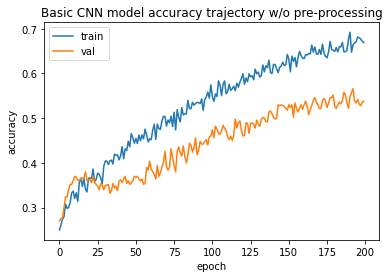

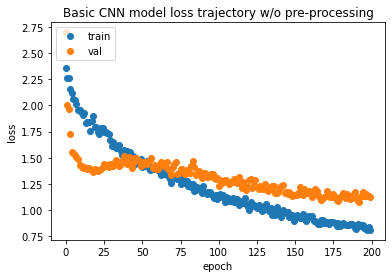

In [28]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory w/o pre-processing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory w/o pre-processing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (CNN) Testing the performance of the basic CNN model on the held out test set

In [29]:
## Testing the basic CNN model
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.5575620532035828


## Defining the architecture of a basic CNN+LSTM model

In [30]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))


# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.6, recurrent_dropout=0.1, return_sequences=False))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 1000, 1, 100)      22100     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 334, 1, 100)      0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 334, 1, 100)      400       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 334, 1, 100)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 334, 1, 100)       100100    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 112, 1, 100)     

## Defining the hyperparameters of the basic CNN model

In [31]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [32]:
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/50
9/9 [==============================] - 60s 4s/step - loss: 1.3832 - accuracy: 0.2663 - val_loss: 1.6038 - val_accuracy: 0.2520
Epoch 2/50
9/9 [==============================] - 32s 4s/step - loss: 1.3518 - accuracy: 0.3158 - val_loss: 1.7350 - val_accuracy: 0.2640
Epoch 3/50
9/9 [==============================] - 33s 4s/step - loss: 1.3244 - accuracy: 0.3437 - val_loss: 1.5477 - val_accuracy: 0.3080
Epoch 4/50
9/9 [==============================] - 30s 3s/step - loss: 1.3054 - accuracy: 0.3789 - val_loss: 1.6270 - val_accuracy: 0.3100
Epoch 5/50
9/9 [==============================] - 30s 3s/step - loss: 1.2642 - accuracy: 0.4099 - val_loss: 1.5202 - val_accuracy: 0.3520
Epoch 6/50
9/9 [==============================] - 30s 3s/step - loss: 1.2419 - accuracy: 0.4396 - val_loss: 1.4883 - val_accuracy: 0.3920
Epoch 7/50
9/9 [==============================] - 31s 3s/step - loss: 1.2341 - accuracy: 0.4180 - val_loss: 1.5045 - val_accuracy: 0.3740
Epoch 8/50
9/9 [==================

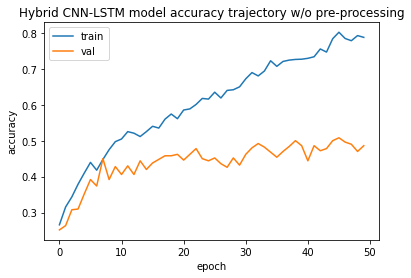

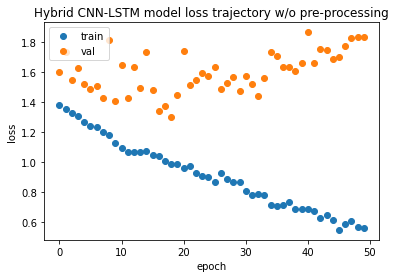

In [33]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory w/o pre-processing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory w/o pre-processing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.4898419976234436
